In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2, fftshift
from scipy.spatial.distance import cdist

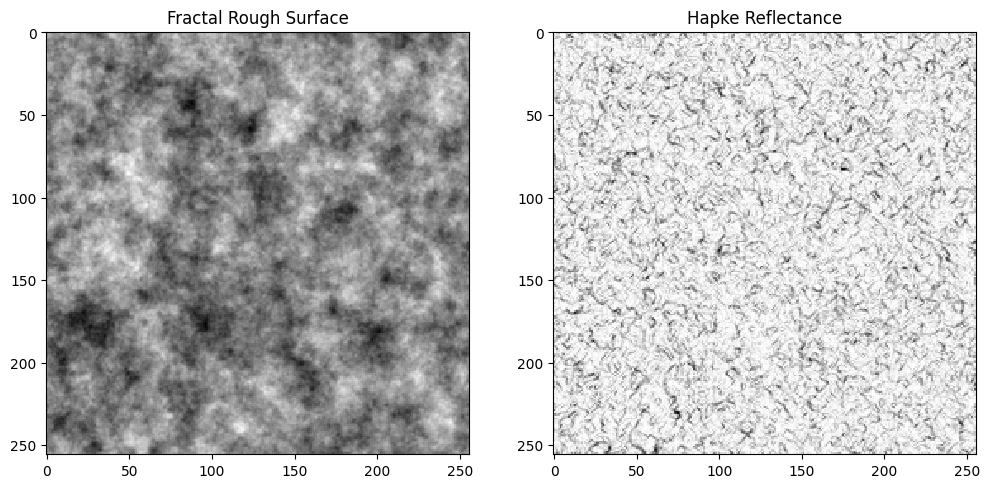

In [ ]:
# Parameters
size = 256  # Grid size
corr_length = 10  # Correlation length (controls roughness)
acf_type = "exponential"  # ACF type: 'exponential' or 'gaussian'
omega = 0.7  # Single-scattering albedo (surface reflectivity)
i = np.radians(30)  # Incidence angle (degrees → radians)
e = np.radians(0)  # Emission angle
g = np.radians(30)  # Phase angle

# Generate 2D grid and distances
x = np.linspace(-size//2, size//2, size)
y = np.linspace(-size//2, size//2, size)
X, Y = np.meshgrid(x, y)
distances = np.sqrt(X**2 + Y**2)

# Define ACF (Autocorrelation Function)
if acf_type == "exponential":
    acf = np.exp(-distances / corr_length)  # Exponential ACF
elif acf_type == "gaussian":
    acf = np.exp(- (distances / corr_length)**2)  # Gaussian ACF
else:
    raise ValueError("Invalid ACF type. Use 'exponential' or 'gaussian'.")

# Generate white noise and filter it using ACF in Fourier space
white_noise = np.random.normal(0, 1, (size, size))
acf_fft = fft2(fftshift(acf))
noise_fft = fft2(white_noise)
filtered_fft = np.sqrt(np.abs(acf_fft)) * noise_fft
heightmap = np.real(ifft2(filtered_fft))  # Inverse transform

# Compute surface normals (gradient of heightmap)
dx, dy = np.gradient(heightmap)
slope = np.sqrt(dx**2 + dy**2)  # Surface slope magnitude
mu0 = np.cos(i) / np.sqrt(1 + slope**2)  # Cosine of local incidence angle
mu = np.cos(e) / np.sqrt(1 + slope**2)  # Cosine of local emission angle

# Hapke Reflectance Model (simplified)
def H_function(omega, mu):
    return (1 + 2 * mu) / (1 + 2 * mu * np.sqrt(1 - omega))

H_mu0 = H_function(omega, mu0)
H_mu = H_function(omega, mu)
reflectance = (omega / 4) * (mu0 / (mu0 + mu)) * (H_mu0 * H_mu - 1)

# Normalize reflectance for visualization
reflectance = (reflectance - np.min(reflectance)) / (np.max(reflectance) - np.min(reflectance))

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Rough surface
ax[0].imshow(heightmap, cmap='gray', interpolation='nearest')
ax[0].set_title("Fractal Rough Surface")

# Hapke reflectance map
ax[1].imshow(reflectance, cmap='gray', interpolation='nearest')
ax[1].set_title("Hapke Reflectance")

plt.show()
